# Classification

## Modelling a baseline model using DummyClassifier

The objective here is to make a baseline model for our classification task so that we could iterate on it and compare our best model against it

In [25]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier 
from sklearn.metrics import(
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

RANDOM_STATE = 17

In [26]:
try:
    df = pd.read_csv("../data/COMP1801_Coursework_Dataset_Corrected.csv")
except FileNotFoundError:
    print(f"Error: Dataset file not found!")
    exit()
df.head()

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,1107.81,Valve,singleGrain,27,2.64,8.08,23.35,60.65,19.76,15.18,4.41,7,0,0,Top,Investment
1,1226.13,Valve,colGrain,24,4.06,1.11,24.98,52.47,31.63,12.32,3.58,30,1,0,Top,Continuous
2,1914.12,Blade,singleGrain,20,4.36,8.54,34.71,60.98,26.56,11.60,0.86,22,0,0,Bottom,Continuous
3,1240.83,Valve,singleGrain,14,3.59,8.83,21.61,54.13,26.71,17.81,1.35,10,0,0,Bottom,Continuous
4,1599.40,Nozzle,singleGrain,22,3.06,3.04,29.65,62.88,24.06,12.08,0.98,21,0,0,Top,Investment


--- Class Distribution ---
1500_labels
0    0.711
1    0.289
Name: proportion, dtype: float64




C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29208\2327927296.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='1500_labels', data=df, palette='pastel', hue=None)


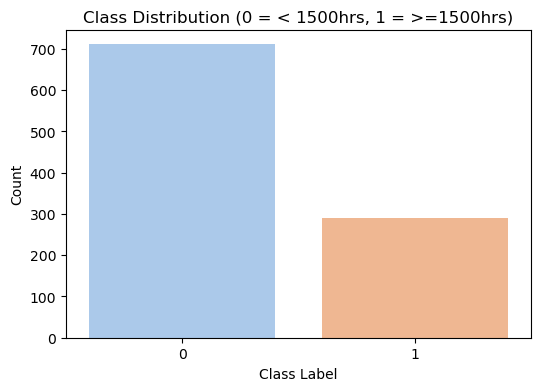

In [27]:
# let us create the binary feature for out classification where threshold == 1500

LIFESPAN_THRESHOLD = 1500
df['1500_labels'] = (df['Lifespan'] >= LIFESPAN_THRESHOLD).astype(int)

# plot & check class balance of TRUE/FALSE (1 or 0)
print("--- Class Distribution ---")
print(df['1500_labels'].value_counts(normalize=True))
print("\n")

plt.figure(figsize=(6, 4))
sns.countplot(x='1500_labels', data=df, palette='pastel', hue=None)
plt.title(f"Class Distribution (0 = < {LIFESPAN_THRESHOLD}hrs, 1 = >={LIFESPAN_THRESHOLD}hrs)")
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.savefig("../report/figures/fig-4.1-class-distribution.png", dpi=500, bbox_inches="tight")
plt.show()

### Class Distribution observations:

1. There is a **strong class imbalance** in the dataset
2. Classes 0:1 has a proportion of nearly **7:3** which is highly imbalanced in the favour of class 0
3. We must make up for this class imbalance using either minority over-sampling or majority undersampling, etc. 
4. Need for right metric **(F1 score, recall)** that shows minority performance 

### pre-processing 

In [28]:
y = df['1500_labels']
X = df.drop(columns=['Lifespan', '1500_labels'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, random_state=RANDOM_STATE
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("-"*30)

Training set shape: (800, 15)
Test set shape: (200, 15)
------------------------------


In [29]:
cat_col = X_train.select_dtypes(include=['object','category']).columns.tolist()
num_col = X_train.select_dtypes(include=['int64','float64']).columns.tolist()

print(f"Categorical columns: {cat_col}")
print(f"Numerical columns: {num_col}")
print("-"*30)

Categorical columns: ['partType', 'microstructure', 'seedLocation', 'castType']
Numerical columns: ['coolingRate', 'quenchTime', 'forgeTime', 'HeatTreatTime', 'Nickel%', 'Iron%', 'Cobalt%', 'Chromium%', 'smallDefects', 'largeDefects', 'sliverDefects']
------------------------------



--- Dummy Classifier (Baseline) Results ---
Dummy Accuracy:  0.7150
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       143
           1       0.00      0.00      0.00        57

    accuracy                           0.71       200
   macro avg       0.36      0.50      0.42       200
weighted avg       0.51      0.71      0.60       200

------------------------------
Logistic Regression Accuracy: 0.7300
Logistic Regression Precision: 0.6000
Logistic Regression Recall: 0.1579
Logistic Regression F1-Score: 0.2500

Full Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84       143
           1       0.60      0.16      0.25        57

    accuracy                           0.73       200
   macro avg       0.67      0.56      0.54       200
weighted avg       0.70      0.73      0.67       200



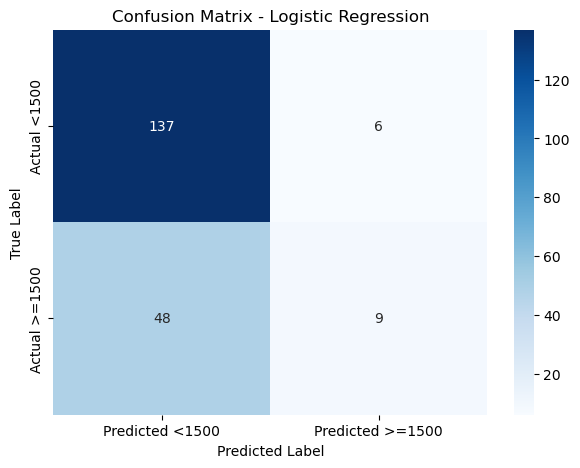

In [30]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler',StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('cat', categorical_transformer, cat_col)
    ],
    remainder='passthrough'
)

print("\n--- Dummy Classifier (Baseline) Results ---")
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)
y_dummy_pred = dummy_clf.predict(X_test)

print(f"Dummy Accuracy: {accuracy_score(y_test, y_dummy_pred): .4f}")
print(classification_report(y_test, y_dummy_pred, zero_division=0))
print("-"*30)

baseline_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', baseline_model)
])

clf_pipeline.fit(X_train, y_train)

y_pred = clf_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Precision: {precision:.4f}")
print(f"Logistic Regression Recall: {recall:.4f}")
print(f"Logistic Regression F1-Score: {f1:.4f}")

print("\nFull Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted <1500', 'Predicted >=1500'], 
            yticklabels=['Actual <1500', 'Actual >=1500'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.savefig("../report/figures/fig-4.2-baseline-classifier-report.png", dpi=500, bbox_inches='tight')
plt.show()

### Baseline classifier result observations:

1. As we hypothesised, the baseline only predicts class 0
2. Even though accuracy is fine, we see the real picture when we see precision and recall being terribly bad
2. Logistic Regression does learn to predict class 1 but does not do well in containing the effects of imbalanced dataset

### Addressing Class Imbalance: Synthetic Minority Over-Sampling Technique

In [31]:
# ! pip install imbalanced-learn

In [32]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 

---Fitting Logistic Regression with SMOTE---
Fit complete!
------------------------------

 ---Logistic Regression with SMOTE Results---
LR + SMOTE Accruacy: 0.6250
LR + SMOTE Precision (Class 1): 0.4082
LR + SMOTE Recall (Class 1): 0.7018
LR + SMOTE F1-Score (Class 1): 0.5161

 Full Classification Report (with SMOTE):
              precision    recall  f1-score   support

           0       0.83      0.59      0.69       143
           1       0.41      0.70      0.52        57

    accuracy                           0.62       200
   macro avg       0.62      0.65      0.61       200
weighted avg       0.71      0.62      0.64       200



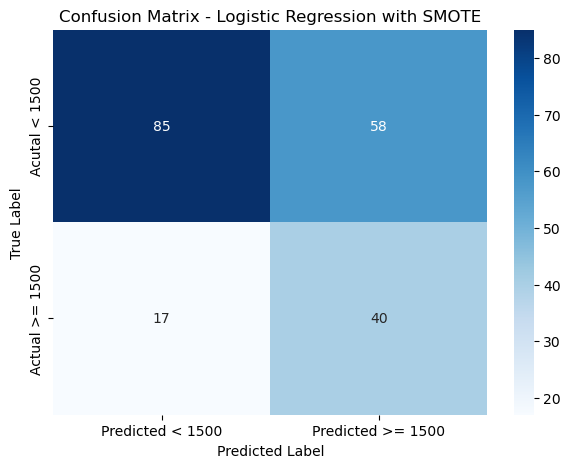

In [33]:
smote = SMOTE(random_state=RANDOM_STATE)

smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', baseline_model)
])

print("---Fitting Logistic Regression with SMOTE---")
smote_pipeline.fit(X_train, y_train)
print("Fit complete!")
print("-"*30)

y_pred_smote = smote_pipeline.predict(X_test)

print("\n ---Logistic Regression with SMOTE Results---")
accuracy_smote = accuracy_score(y_test, y_pred_smote)
precision_score = precision_score(y_test, y_pred_smote)
recall_smote=recall_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)

print(f"LR + SMOTE Accruacy: {accuracy_smote:.4f}")
print(f"LR + SMOTE Precision (Class 1): {precision_score:.4f}")
print(f"LR + SMOTE Recall (Class 1): {recall_smote:.4f}")
print(f"LR + SMOTE F1-Score (Class 1): {f1_smote:.4f}")

print("\n Full Classification Report (with SMOTE):")
print(classification_report(y_test, y_pred_smote))

cm_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted < 1500', 'Predicted >= 1500'],
            yticklabels=['Acutal < 1500', 'Actual >= 1500'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression with SMOTE')
plt.savefig("../report/figures/fig-4.3-SMOTE-classifier-report.png", dpi=500, bbox_inches='tight')
plt.show()

### SMOTE Observations:

1. We can clearly see that SMOTE has produced **significantly better** results
2. Recall for logistic regression went from 0.16 in non-SMOTE model to 0.7018 in the SMOTE model
3. We also see their is a drop in precision score from non-smote model to smote model as it expected since we are trying harder to find class 1
4. F1 score more than doubles in the SMOTE model to 0.5101 
5. Overall accuracy went down from 0.6300 in non-SMOTE model to 0.6250 in the SMOTE model, which is good because now the classes are more balanced

### Feature Crafting

#### 1a. Find the Optimal Number of Clusters

We will use Inertia formula to find tight and coherent clusters within our dataset:

$$
\text{Inertia} = \sum_{i=1}^{K} \sum_{x \in C_i} \| x - \mu_i \|^2
$$


c:\Users\Lenovo\miniconda3\envs\comp1801-ml\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Lenovo\miniconda3\envs\comp1801-ml\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Lenovo\miniconda3\envs\comp1801-ml\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Lenovo\miniconda3\envs\comp1801-ml\lib\site-packages\sklearn\cluster\_

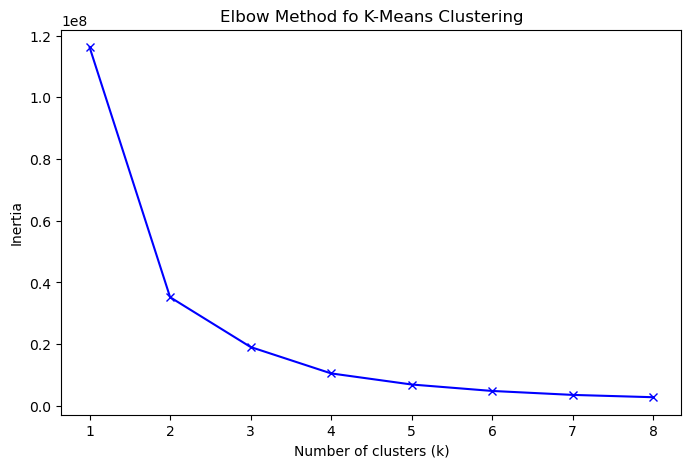

In [34]:
from sklearn.cluster import KMeans

lifespan_data = df[['Lifespan']] 

inertia = []
k_values = range(1, 9)

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    kmeans.fit(lifespan_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method fo K-Means Clustering')
plt.savefig("../report/figures/fig-4.4-number-of-clusters.png", dpi=500, bbox_inches='tight')
plt.show()

#### Elbow Method observations:

1. We can clearly observe 'elbow'(bend) at k=3
2. We can see a sharp decline and then eventual flattening out of inertia at **cluster = 3**
2. This provides us evidence of clustering our multi-class classification into **3 distinct categories/clusters**

#### 1b. Crafting 3 new labels:

In [35]:
N_CLUSTERS = 3

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=10, random_state=RANDOM_STATE)
df['multi_class_label'] = kmeans.fit_predict(lifespan_data)

print("---KMeans Cluster Descriptions---")
print(df.groupby('multi_class_label')['Lifespan'].describe())

---KMeans Cluster Descriptions---
                   count         mean         std      min        25%  \
multi_class_label                                                       
0                  346.0  1664.300636  162.390337  1439.88  1533.0225   
1                  407.0  1214.972924  114.624816  1037.22  1109.6150   
2                  247.0   856.130040  137.202850   359.71   776.6850   

                        50%        75%      max  
multi_class_label                                
0                  1619.135  1798.6025  2046.41  
1                  1206.330  1312.4750  1437.26  
2                   890.580   958.7700  1033.27  


c:\Users\Lenovo\miniconda3\envs\comp1801-ml\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Based on our results of mean of the respective clusters we have the following:

1. cluster 0 --> "High"
2. cluster 1 --> "Medium"
3. cluster 2 --> "Low"

We must remap them to be logical


 --- New Multi-class Class Distribution ---
multi_class_label
1    0.407
2    0.346
0    0.247
Name: proportion, dtype: float64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29208\2908897937.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='multi_class_label', data=df, palette='pastel')


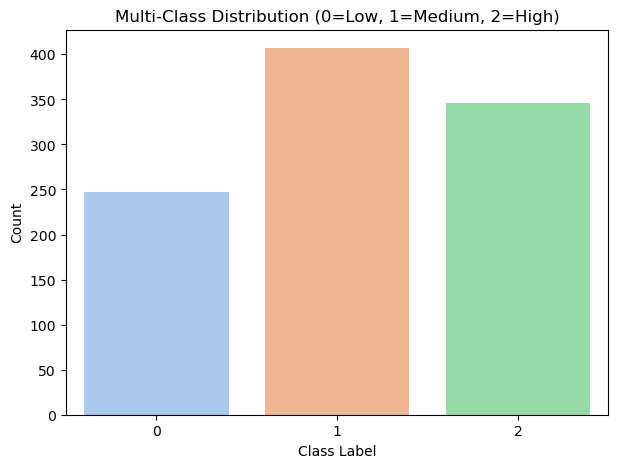

In [36]:
label_map = {
    2:0,
    1:1,
    0:2
}

df['multi_class_label'] = df['multi_class_label'].map(label_map)

print("\n --- New Multi-class Class Distribution ---")
print(df['multi_class_label'].value_counts(normalize=True))

plt.figure(figsize=(7,5))
sns.countplot(x='multi_class_label', data=df, palette='pastel')
plt.title("Multi-Class Distribution (0=Low, 1=Medium, 2=High)")
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.savefig("../report/figures/fig-4.5-multi-class-distribution.png", dpi=500, bbox_inches='tight')
plt.show()

### New Training Set-up 

In [37]:
y_multi = df['multi_class_label']

X_multi = df.drop(columns=['Lifespan','1500_labels','multi_class_label'])

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y_multi
)

print(f"New training set shape is: {X_train_multi.shape}")
print(f"New Test Set shape is: {X_test_multi.shape}")

New training set shape is: (800, 15)
New Test Set shape is: (200, 15)


### **Experiment 1**:

#### Modelling Gussian Mean Mixture + SMOTE Pipeline:

In [50]:
from sklearn.mixture import GaussianMixture

In [51]:
gmm_classifier_multi = GaussianMixture(n_components=2, random_state=RANDOM_STATE)

smote_multi = SMOTE(random_state=RANDOM_STATE)

gmm_smote_pipeline_multi = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote_multi),
    ('classifier', gmm_classifier_multi)
])

print("\n Fitting GMM Classifier (Multi-Class) with SMOTE")
gmm_smote_pipeline_multi.fit(X_train_multi, y_train_multi)
print("\n Fit Complete")
print("-"*30)

y_pred_gmm_multi = gmm_smote_pipeline_multi.predict(X_test_multi)


 Fitting GMM Classifier (Multi-Class) with SMOTE

 Fit Complete
------------------------------


c:\Users\Lenovo\miniconda3\envs\comp1801-ml\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


c:\Users\Lenovo\miniconda3\envs\comp1801-ml\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\miniconda3\envs\comp1801-ml\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\miniconda3\envs\comp1801-ml\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital


--- GMM Classifier (Multi-Class) with SMOTE Results ---
GMM + SMOTE Accuracy: 0.3100
GMM + SMOTE Precision (Weighted): 0.2283
GMM + SMOTE Recall (Weighted): 0.3100
GMM + SMOTE F1-Score (Weighted): 0.2458

Full Classification Report (GMM Multi-Class with SMOTE):
              precision    recall  f1-score   support

         Low       0.26      0.67      0.37        49
      Medium       0.40      0.35      0.38        82
        High       0.00      0.00      0.00        69

    accuracy                           0.31       200
   macro avg       0.22      0.34      0.25       200
weighted avg       0.23      0.31      0.25       200



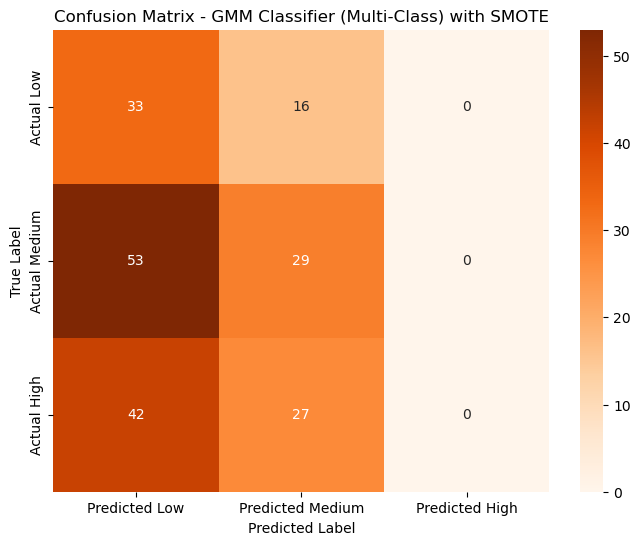

In [52]:
# --- 1. Evaluate the results ---
print("\n--- GMM Classifier (Multi-Class) with SMOTE Results ---")

# For multi-class, we should use 'weighted' or 'macro' averaging
# for precision, recall, and F1.
accuracy_gmm_multi = accuracy_score(y_test_multi, y_pred_gmm_multi)
precision_gmm_multi = precision_score(y_test_multi, y_pred_gmm_multi, average='weighted')
recall_gmm_multi = recall_score(y_test_multi, y_pred_gmm_multi, average='weighted')
f1_gmm_multi = f1_score(y_test_multi, y_pred_gmm_multi, average='weighted')

print(f"GMM + SMOTE Accuracy: {accuracy_gmm_multi:.4f}")
print(f"GMM + SMOTE Precision (Weighted): {precision_gmm_multi:.4f}")
print(f"GMM + SMOTE Recall (Weighted): {recall_gmm_multi:.4f}")
print(f"GMM + SMOTE F1-Score (Weighted): {f1_gmm_multi:.4f}")

print("\nFull Classification Report (GMM Multi-Class with SMOTE):")
# This report is now your most important metric
print(classification_report(y_test_multi, y_pred_gmm_multi, target_names=['Low', 'Medium', 'High']))

# --- 2. Plot the new 3x3 confusion matrix ---
cm_gmm_multi = confusion_matrix(y_test_multi, y_pred_gmm_multi)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gmm_multi, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Predicted Low', 'Predicted Medium', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual Medium', 'Actual High'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - GMM Classifier (Multi-Class) with SMOTE')
plt.show()

#### **GMM Modelling Obersvations**:

1. GMM is failing to Identify even a single 'High' Class data
2. The model has completely failed to learn 'High' pattern and is basically guessing
3. This suggests us that the **shapes of the three classes are strongly overlapping and consufing**

### **Experiment 2:**

#### Modelling Random Forest Multi-class Classifier 

Let us try with a more robust and discriminative model, Random Forest on the same SMOTE dataset. These models are good non-linear models.

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score


 ---Fitting RandomForest (Multi-Class) with SMOTE---
Fit complete.
------------------------------
              precision    recall  f1-score   support

         Low       0.85      0.71      0.78        49
      Medium       0.75      0.80      0.78        82
        high       0.86      0.88      0.87        69

    accuracy                           0.81       200
   macro avg       0.82      0.80      0.81       200
weighted avg       0.81      0.81      0.81       200



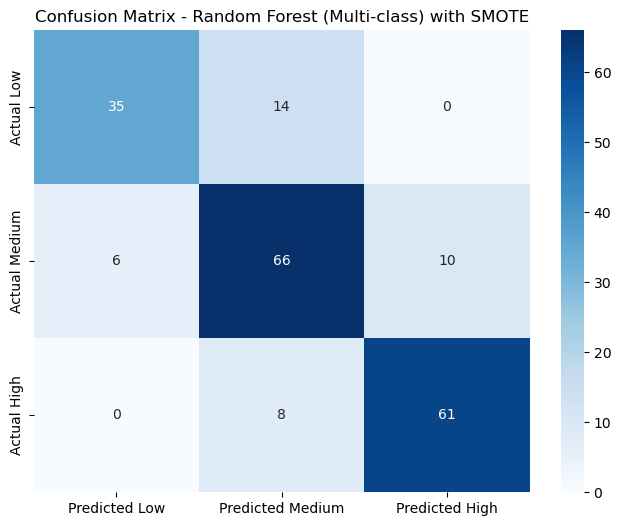

In [49]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=RANDOM_STATE)

rf_smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote_multi),
    ('classifier',rf_classifier)
])

print("\n ---Fitting RandomForest (Multi-Class) with SMOTE---")
rf_smote_pipeline.fit(X_train_multi, y_train_multi)
print("Fit complete.")
print("-"*30)

y_pred_rf = rf_smote_pipeline.predict(X_test_multi)
print(classification_report(y_test_multi, y_pred_rf, target_names=['Low', 'Medium', 'high']))

cm_rf = confusion_matrix(y_test_multi, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Low', 'Predicted Medium', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual Medium', 'Actual High'])
plt.title('Confusion Matrix - Random Forest (Multi-class) with SMOTE')
plt.show()

#### Random Forest Classifer Observations:

1. We have a remarkebly better results as compared to GMM classifier
2. "High" class is now performing at 0.87 F1 score
3. macro avg is 0.81 which indicates that our model is good at all three classes

In [56]:
from sklearn.model_selection import GridSearchCV

rf_pipeline_tuning = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote_multi),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

param_grid = {
    'classifier__n_estimators': [100, 200],    
    'classifier__max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(rf_pipeline_tuning, param_grid, cv=5, 
                           scoring='f1_macro', verbose=2, n_jobs=-1)


print("\n--- Tuning RandomForest with GridSearchCV ---")
grid_search.fit(X_train_multi, y_train_multi)


print("\nBest parameters found:")
print(grid_search.best_params_)


print("\n--- Final Tuned RandomForest Results ---")
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_multi)

print("\nFull Classification Report (Tuned RandomForest):")
print(classification_report(y_test_multi, y_pred_best, target_names=['Low', 'Medium', 'High']))


--- Tuning RandomForest with GridSearchCV ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters found:
{'classifier__max_depth': None, 'classifier__n_estimators': 200}

--- Final Tuned RandomForest Results ---

Full Classification Report (Tuned RandomForest):
              precision    recall  f1-score   support

         Low       0.83      0.71      0.77        49
      Medium       0.76      0.80      0.78        82
        High       0.87      0.90      0.89        69

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200

